In [1]:
import medmnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim import SGD
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn
from torchvision.transforms import transforms

In [2]:
import torch.optim as optim
import torch.nn.functional as F

In [23]:
from torch import nn
from FedUtils.models.utils import Flops, FSGM
import torch
import sys


class Reshape(nn.Module):
    def forward(self, x):
        return x.reshape(-1, 576)


class Model(nn.Module):
    def __init__(self, num_classes, optimizer=None, learning_rate=None, seed=1, p_iters=10, ps_eta=0.1, pt_eta=0.001):
        super(Model, self).__init__()
        self.num_classes = num_classes
        self.num_inp = 784
        torch.manual_seed(seed)

        self.net = nn.Sequential(*[nn.Conv2d(1, 32, 5),
                                   nn.ReLU(), 
                                   nn.Conv2d(32, 32, 5), 
                                   nn.MaxPool2d(2), 
                                   nn.ReLU(), 
                                   nn.Conv2d(32, 64, 5),
                                   nn.MaxPool2d(2), 
                                   nn.ReLU(), 
                                   Reshape(), 
                                   nn.Linear(576, 256), 
                                   nn.ReLU(), 
                                   nn.Linear(256, self.num_classes)]
                                )
        self.size = sys.getsizeof(self.state_dict())
        self.softmax = nn.Softmax(-1)


        if optimizer is not None:
            self.optimizer = optimizer(self.parameters(), lr=0.1)
        else:
            assert learning_rate, "should provide at least one of optimizer and learning rate"
            self.learning_rate = learning_rate

        self.p_iters = p_iters
        self.ps_eta = ps_eta
        self.pt_eta = pt_eta

        self.flop = Flops(self, torch.tensor([[0.0 for _ in range(self.num_inp)]]))
        if torch.cuda.device_count() > 0:
            self.net = self.net.cuda()

    def set_param(self, state_dict):
        self.load_state_dict(state_dict)
        return True

    def get_param(self):
        return self.state_dict()

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            return self.softmax(self.forward(x))

    def generate_fake(self, x, y):
        self.eval()
        psuedo, perturb = x.detach(), x.detach()
        if psuedo.device != next(self.parameters()).device:
            psuedo = psuedo.to(next(self.parameters()).device)
            perturb = perturb.to(next(self.parameters()).device)
        psuedo = FSGM(self, psuedo, y, self.p_iters, self.ps_eta)
        perturb = FSGM(self, perturb, y, self.p_iters, self.pt_eta)
        psuedo_y, perturb_y = self.predict(psuedo), self.predict(perturb)
        return [psuedo, y, psuedo_y], [perturb, y, perturb_y]

    def loss(self, pred, gt):
        pred = self.softmax(pred)
        if gt.device != pred.device:
            gt = gt.to(pred.device)
        if len(gt.shape) != len(pred.shape):
            gt = nn.functional.one_hot(gt.long(), self.num_classes).float()
        assert len(gt.shape) == len(pred.shape)
        loss = -gt*torch.log(pred+1e-12)
        loss = loss.sum(1)
        return loss

    def forward(self, data):
        if data.device != next(self.parameters()).device:
            data = data.to(next(self.parameters()).device)
        data = data.reshape(-1, 1, 28, 28)
        out = self.net(data)
        return out

    def train_onestep(self, data):
        self.train()
        self.zero_grad()
        self.optimizer.zero_grad()
        x, y = data
        pred = self.forward(x)
        loss = self.loss(pred, y).mean()
        loss.backward()
        self.optimizer.step()
        return self.flop*len(x), loss

    def solve_inner(self, data, num_epochs=1, step_func=None):
        comp = 0.0
        weight = 1.0
        steps = 0
        if step_func is None:
            func = self.train_onestep
        else:
            func = step_func(self, data)

        for _ in range(num_epochs):
            for x, y in data:
                c = func([x, y])
                comp += c
                steps += 1.0
        soln = self.get_param()
        return soln, comp, weight

    def test(self, data):
        tot_correct = 0.0
        loss = 0.0
        self.eval()
        # print(f"data is of type {type(data)} and of length {len(data)}")
        # d is a tensor of shape (100,28,28)
        x, y = data
        with torch.no_grad():
            pred = self.forward(x)
        loss += self.loss(pred, y).sum()
        pred_max = pred.argmax(-1).unsqueeze(1).float()
        # print(pred_max.shape)
        # print(y.shape)
        assert len(pred_max.shape) == len(y.shape)
        if pred_max.device != y.device:
            pred_max = pred_max.detach().to(y.device)
        tot_correct += (pred_max == y).float().sum()
        return tot_correct, loss

torch.Size([1, 28, 28])
GGG
torch.Size([28, 28, 1])


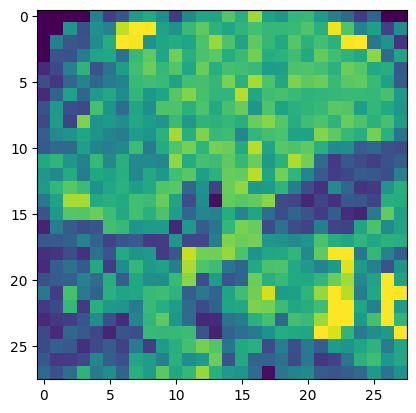

In [22]:
im1 = train_dataset[0][0]
print(im1.shape)
print("GGG")
im1 = im1.permute((1,2,0))
print(im1.shape)
plt.imshow(im1)

In [28]:
class altModel(nn.Module):
    def __init__(self, num_classes):
        super(altModel, self).__init__()
        self.net = nn.Sequential(*[nn.Conv2d(1, 32, 5),
                                   nn.ReLU(), 
                                   nn.Conv2d(32, 32, 5), 
                                   nn.MaxPool2d(2), 
                                   nn.ReLU(), 
                                   nn.Conv2d(32, 64, 5),
                                   nn.MaxPool2d(2), 
                                   nn.ReLU(), 
                                   Reshape(), 
                                   nn.Linear(576, 256), 
                                   nn.ReLU(), 
                                   nn.Linear(256, num_classes)]
                                )
    def forward(self, data):
        return self.net(data)
    


In [55]:
data_transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize(mean=[.5], std=[.5])])
train_dataset = getattr(medmnist, medmnist.INFO["breastmnist"]["python_class"])(root="./data", split="train", transform=data_transform)
num_classes = len(np.unique(train_dataset.labels))
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [56]:
imgs = []
labels = []
for data in train_loader:
    imgs.append(data[0])
    labels.append(data[1])

In [57]:
print(labels[:10])

[tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1]]), tensor([[0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1]]), tensor([[0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1]]), tensor([[0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1]]), tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]]), tensor([[1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1]]), tensor([[1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0]]), tensor([[1],
        [1],
        [0],
        [1],
        [1],
        [1

In [32]:
print(len(imgs))
print(len(labels))

3459
3459


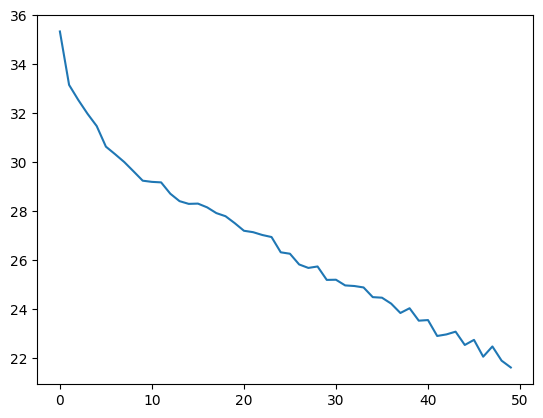

In [89]:
losses = []
model = altModel(num_classes=num_classes)
optimizer = optim.SGD(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()
num_epochs = 50
model.train()
accs = []
for epoch in range(num_epochs):
    # print(f"epoch {epoch+1}")
    temp = 0
    for data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(data.float())
        loss = criterion(outputs, labels.flatten())
        # if i == 0:
        #     print("this")
        #     print(outputs)
        #     print(torch.argmax(labels, 1))
        #     print(loss)
        #     print("end")
        # print(loss)
        # if loss.item()==0:
        #     exit()
        # Backward pass
        # print("****************")
        # print("labels",labels.flatten())
        # print("outputs",torch.argmax(outputs, 1))
        # print("****************")
        # print(torch.sum(torch.argmax(outputs, 1) == labels.flatten()))
        # if i == 3:
            # break
        # acc = np.sum(torch.argmax(outputs, 1) == torch.argmax(labels, 1))/ len(data)
        # accs.append(acc)
        loss.backward()
        optimizer.step()
        temp += loss.item()
    losses.append(np.mean(temp))
            

plt.plot(losses)
plt.show()

In [63]:
data_transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize(mean=[.5], std=[.5])])
test_dataset = getattr(medmnist, medmnist.INFO["breastmnist"]["python_class"])(root="./data", split="test", transform=data_transform)
num_classes = len(np.unique(test_dataset.labels))
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

In [76]:
acc = 0
total = 0
n = 0
with torch.no_grad():
    for data, labels in tqdm(test_loader):
        outputs = model(data.float())
        total+= len(data)
        acc += np.equal(np.argmax(outputs.numpy(),1), labels.flatten()).sum()
        if n ==0:
            print(labels.flatten())
            print(np.argmax(outputs.numpy(),1))
            n += 1
print(acc/total)

100%|██████████| 16/16 [00:00<00:00, 105.43it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
[1 1 1 1 1 1 1 1 1 1]
tensor(0.8205)


In [92]:
from enum import unique
from logging import root
from cv2 import split, transform
from sklearn.utils import shuffle
from torch import nn
from FedUtils.models.utils import Flops, FSGM
import torch
import sys


class Reshape(nn.Module):
    def forward(self, x):
        return x.reshape(-1, 576)


class Model(nn.Module):
    def __init__(self, num_classes, optimizer=None, learning_rate=None, seed=1, p_iters=10, ps_eta=0.1, pt_eta=0.001):
        super(Model, self).__init__()
        self.num_classes = num_classes
        self.num_inp = 784
        torch.manual_seed(seed)
        self.criterion = nn.CrossEntropyLoss()
        self.net = nn.Sequential(*[nn.Conv2d(1, 32, 5),
                                   nn.ReLU(), 
                                   nn.Conv2d(32, 32, 5), 
                                   nn.MaxPool2d(2), 
                                   nn.ReLU(), 
                                   nn.Conv2d(32, 64, 5),
                                   nn.MaxPool2d(2), 
                                   nn.ReLU(), 
                                   Reshape(), 
                                   nn.Linear(576, 256), 
                                   nn.ReLU(), 
                                   nn.Linear(256, self.num_classes)]
                                )
        self.size = sys.getsizeof(self.state_dict())
        self.softmax = nn.Softmax(-1)


        if optimizer is not None:
            self.optimizer = optimizer(self.parameters(), lr=learning_rate)
        else:
            assert learning_rate, "should provide at least one of optimizer and learning rate"
            self.learning_rate = learning_rate

        self.p_iters = p_iters
        self.ps_eta = ps_eta
        self.pt_eta = pt_eta

        self.flop = Flops(self, torch.tensor([[0.0 for _ in range(self.num_inp)]]))
        if torch.cuda.device_count() > 0:
            self.net = self.net.cuda()

    def set_param(self, state_dict):
        self.load_state_dict(state_dict)
        return True

    def get_param(self):
        return self.state_dict()

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            return self.softmax(self.forward(x))

    def generate_fake(self, x, y):
        self.eval()
        psuedo, perturb = x.detach(), x.detach()
        if psuedo.device != next(self.parameters()).device:
            psuedo = psuedo.to(next(self.parameters()).device)
            perturb = perturb.to(next(self.parameters()).device)
        psuedo = FSGM(self, psuedo, y, self.p_iters, self.ps_eta)
        perturb = FSGM(self, perturb, y, self.p_iters, self.pt_eta)
        psuedo_y, perturb_y = self.predict(psuedo), self.predict(perturb)
        return [psuedo, y, psuedo_y], [perturb, y, perturb_y]

    def loss(self, pred, true):
        return self.criterion(pred, true.flatten())
        
    # def loss(self, pred, gt):
        # pred = self.softmax(pred)
        # if gt.device != pred.device:
            # gt = gt.to(pred.device)
        # if len(gt.shape) != len(pred.shape):
            # gt = nn.functional.one_hot(gt.long(), self.num_classes).float()
        # assert len(gt.shape) == len(pred.shape)
        # loss = -gt*torch.log(pred+1e-12)
        # loss = loss.sum(1)
        # return loss

    def forward(self, data):
        if data.device != next(self.parameters()).device:
            data = data.to(next(self.parameters()).device)
        data = data.reshape(-1, 1, 28, 28)
        out = self.net(data)
        return out

    def train_onestep(self, data):
        self.train()
        self.zero_grad()
        self.optimizer.zero_grad()
        x, y = data
        x, y = x.float(), y.float()
        pred = self.forward(x)
        loss = self.loss(pred, y).mean()
        loss.backward()
        self.optimizer.step()
        return self.flop*len(x), loss

    def solve_inner(self, data, num_epochs=1, step_func=None):
        comp = 0.0
        weight = 1.0
        steps = 0
        if step_func is None:
            func = self.train_onestep
        else:
            func = step_func(self, data)

        for _ in range(num_epochs):
            for x, y in data:
                c = func([x, y])
                comp += c
                steps += 1.0
        soln = self.get_param()
        return soln, comp, weight

    def test(self, data):
        tot_correct = 0.0
        loss = 0.0
        self.eval()
        # print(f"data is of type {type(data)} and of length {len(data)}")
        # d is a tensor of shape (100,28,28)
        x, y = data
        with torch.no_grad():
            pred = self.forward(x)
        loss += self.loss(pred, y).sum()
        pred_max = pred.argmax(-1).unsqueeze(1).float()
        # print(pred_max.shape)
        # print(y.shape)
        assert len(pred_max.shape) == len(y.shape)
        if pred_max.device != y.device:
            pred_max = pred_max.detach().to(y.device)
        tot_correct += (pred_max == y).float().sum()
        return tot_correct, loss

torch.Size([10, 2]) torch.Size([10, 1])


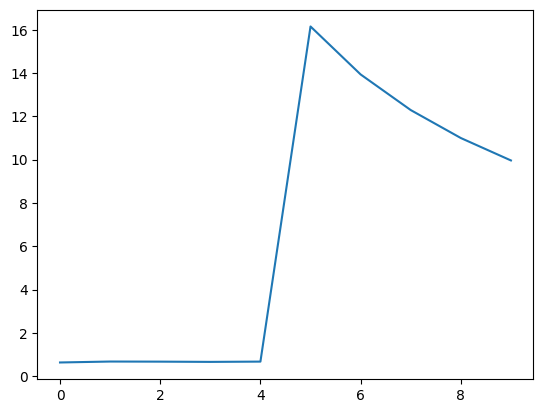

9.963107209192081


In [100]:
losses = []
model = Model(num_classes=2, optimizer=optim.SGD, learning_rate=0.1, seed=1)
criterion = nn.CrossEntropyLoss()
num_epochs = 10
i = 0
model.train()
losses = []
temp = []
for epoch in range(num_epochs):
    for imgs, labels in train_loader:
        outputs = model.forward(imgs)
        if i == 0:
            print(outputs.shape, labels.shape)
            i+=1
        loss = model.loss(outputs, labels)
        loss.backward()
        model.optimizer.step()
        temp.append(loss.item())
    losses.append(np.mean(temp))
plt.plot(losses)
plt.show()
print(losses[-1])

In [122]:
model.eval()
true = []
predictions = []
for imgs , labels in test_loader:
    with torch.no_grad():
        predictions.append(model.predict(imgs).numpy())
        true.append(labels.flatten().numpy())
true = true[:-1]
predictions = predictions[:-1]

In [123]:
print(*[i.shape for i in true])

[array([1, 1, 0, 1, 1, 1, 1, 0, 1, 0]), array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1]), array([1, 0, 1, 1, 1, 1, 1, 1, 0, 0]), array([1, 0, 1, 1, 1, 0, 1, 1, 0, 1]), array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1]), array([0, 1, 1, 1, 1, 0, 1, 1, 1, 0]), array([1, 0, 1, 1, 1, 0, 0, 1, 1, 1]), array([1, 0, 1, 0, 1, 0, 1, 1, 0, 1]), array([0, 1, 1, 1, 0, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([0, 1, 0, 1, 0, 0, 1, 0, 1, 1]), array([1, 1, 0, 1, 1, 1, 0, 1, 1, 0]), array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1]), array([1, 1, 0, 1, 1, 0, 0, 0, 1, 1])]
[array([[0.55766433, 0.4423356 ],
       [0.55766433, 0.4423356 ],
       [0.55766433, 0.4423356 ],
       [0.55766433, 0.4423356 ],
       [0.55766433, 0.4423356 ],
       [0.55766433, 0.4423356 ],
       [0.55766433, 0.4423356 ],
       [0.55766433, 0.4423356 ],
       [0.55766433, 0.4423356 ],
       [0.55766433, 0.4423356 ]], dtype=float32), array([[0.55766433, 0.4423356 ],
       [0.55766433, 0.4423356 ],
